## TARGET PROBABILITY
In this experiment, we would attempt to calculate the probability of a price target getting reached, within a period of time.

### PARAMETERS
- Forecast time range - `t_lback`
- Forecast time range = `t_delta`

#### PROCEDURE

###### Feature Engineering
- Calculate the ATR with a period of `t_lback`
- Compute the closing price returns; price change from the previous data point
- Compute the maximum and minimum price displacement from the current price.
- Compute the ratios of the maximum/minimum price displacement

###### Probability Analysis
- Compute the distribution of assets return, over t_delta bars. Derive the standard deviation of the returns, and the proportion of data within 1, 2, and 3 STD
- Compute the probability of a target being reached; the probability of selecting an asset return equal to or greater than the target

In [398]:
# Parameters
t_lback = 14
t_delta = 14
p_value = 0.05

In [399]:
# Import the data
import pandas as pd
from pathlib import Path
import pandas_ta as ta
import quantstats as qt #noqa
import numpy as np
import seaborn as sns #noqa
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad


aapl_path = Path.cwd().parent / 'data/aapl_h1.csv'
btc_path = Path.cwd().parent / 'data/btcusdt_h1.parquet'

In [445]:
# Functions
def get_distribution(data, title):
    mean = np.mean(data)
    std = np.std(data)
    median = np.median(data)
    
    print("Mean : ", mean)
    print("Standard Deviation : ", std)
    
    # Plot the distribution
    plt.hist(data, bins=30, color='lightblue', edgecolor='black') 

    # Add vertical line at the median using plt.axvline
    plt.axvline(x=mean, color='blue', linestyle='--', label='Mean')
    plt.axvline(x=median, color='red', linestyle='--', label='Median')

    # Customization
    plt.title(f"Distribution of {title}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()  # Show the label

    plt.show()

def target_probability(data, test_value):
    """
    Calculates the probability of the target getting reached.
    
    Args:
        data (array-like): An array containing the distribution of values.
        test_value: The value to test against.
        
    Returns:
        float: The probability of selecting a number below the test value.
    """
    
    # Find the number of data points less than or equal to the test value
    count = np.sum(data >= test_value)
    
    # Calculate the probability
    probability = count / len(data)
    
    return round(probability, 2)

def target_probability_kde(data, test_value):
    """
    Calculates the probability of selecting a number greater than or equal to a test value
    using Kernel Density Estimation (KDE), with integration bounds adjusted for robustness.
    
    Args:
        data (array-like): An array containing the distribution of values.
        test_value (float): The value to test against.
        
    Returns:
        float: The probability of selecting a number above or equal to the test value.
    """
    # Define KDE
    kde = gaussian_kde(data)
    
    # Calculate standard deviation for the bounds
    std = np.std(data)
    upper_bound = max(data) + (3 * std)
    
    # Integration from test_value to upper bound for the probability
    probability, _ = quad(kde, test_value, upper_bound)
    
    return round(probability, 2)

In [416]:
# Read Data
# raw_data = pd.read_parquet(btc_path)
# raw_data.reset_index(names=['datetime'], inplace=True)

raw_data = pd.read_csv(aapl_path)
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])
raw_data.head(3)

,datetime,open,high,low,close,volume
0,1998-01-02 16:00:00,0.12,0.12,0.12,0.12,14512400
1,1998-01-02 17:00:00,0.12,0.13,0.12,0.12,52987312
2,1998-01-02 18:00:00,0.12,0.13,0.12,0.13,23746800


In [386]:
# FEATURE ENGINEERING

# Filter the date range
data = raw_data[(raw_data['datetime'].dt.year >= 2010) & (raw_data['datetime'].dt.year <= 2023)]
data = data.reset_index(drop=True)

# Compute Returns
returns = data['close'].diff().fillna(0)
# returns = data['close'].pct_change().fillna(0)

# Handle Outlier in Returns : Replace with the mean
mean_return = np.mean(returns)
returns.loc[returns.abs() > np.percentile(returns.abs(), 99)] = mean_return # Replace outliers: returns greater than 99th percentile

# Feature Engineering
data['next_returns'] = returns.shift(-1)
data['atr'] = ta.atr(data['high'], data['low'], data['close'], t_lback)

data['max_runup'] = data['next_returns'].rolling(t_delta).apply(
    lambda x : max(
        np.cumsum(
            np.pad(x, (1, 0), mode='constant', constant_values=0)))).shift(-t_delta) # Gets the max drawdown from the next [lookback] bars

data['max_rundown'] = data['next_returns'].rolling(t_delta).apply(
    lambda x : min(
        np.cumsum(
            np.pad(x, (1, 0), mode='constant', constant_values=0)))).shift(-t_delta) # Gets the max drawdown from the next [lookback] bars

data['runup_atr_ratio'] = data['max_runup'] / data['atr']
data['rundown_atr_ratio'] = data['max_rundown'] / data['atr']

# Drop NaNs
data = data.dropna(axis=0)

full_data = data.copy()
data = data.drop(['open', 'high', 'low', 'volume', 'datetime'], axis=1)

# Print Sample
display(data.shape)
data.head(3)


(25223, 7)

,close,next_returns,atr,max_runup,max_rundown,runup_atr_ratio,rundown_atr_ratio
14,7.65,0.01,0.037857,0.0,-0.18,0.0,-4.754717
15,7.66,-0.04,0.037296,0.0,-0.14,0.0,-3.753762
16,7.62,-0.03,0.039632,0.0,-0.11,0.0,-2.775540


In [417]:
test_data = data['runup_atr_ratio'].dropna().to_numpy()

In [448]:
val = .5
target_probability(test_data, val), target_probability_kde(test_data, val)

(0.72, 0.72)

0.37475270722056586

Mean :  1.8953669137170244
Standard Deviation :  2.058875594917536


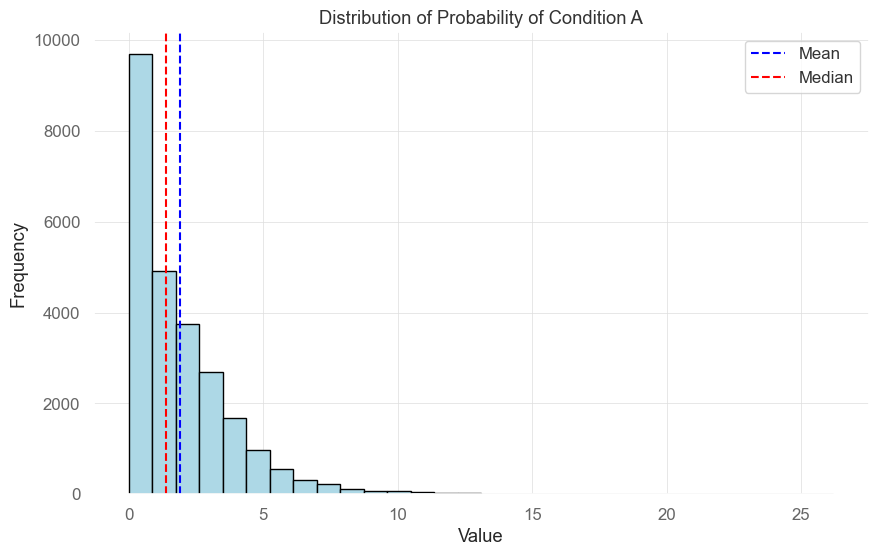

In [443]:
get_distribution(data['runup_atr_ratio'], 'Probability of Condition A')